In [42]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os, re, glob, parse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('muted')

ligan_root = 'C:\\Users\mtr22\Code\liGAN'
sys.path.append(ligan_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# load train experiment output files
train_files = [
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights\\crc_loss_weights.train_output',
]
expt_param_names = ['expt_name', 'cluster']

train_dfs = []
for train_file in train_files:
    train_df = pd.read_csv(train_file, sep=' ')
    cluster, expt_name = os.path.splitext(os.path.basename(train_file))[0].split('_', 1)
    train_df['expt_name'] = expt_name
    train_df['cluster'] = cluster
    train_dfs.append(train_df)
    print(train_file)
        
train_df = pd.concat(train_dfs)

C:\Users\mtr22\Code\liGAN\train_molport\loss_weights\crc_loss_weights.train_output


In [44]:
# parse training params from job names
from functools import lru_cache

job_param_names = ['job_name', 'variational', 'gen_loss_type', 'disc_loss_type', 'random_seed',
                   'KL_loss_weight', 'L2_loss_weight', 'GAN_loss_weight']

vae_job_name_format  = 'gen_{gen_loss_type}_{KL_loss_weight}_{L2_loss_weight}_disc_{disc_loss_type}_{GAN_loss_weight}_{random_seed}'

@lru_cache(100)
def parse_job_name(job_name):

    job_params = parse.parse(vae_job_name_format, job_name).named

    job_params['job_name'] = job_name
    job_params['variational'] = True
    
    # convert data types of numeric params
    job_params['KL_loss_weight'] = float(job_params['KL_loss_weight'])
    job_params['L2_loss_weight'] = float(job_params['L2_loss_weight'])
    job_params['GAN_loss_weight'] = float(job_params['GAN_loss_weight'])

    return pd.Series([job_params[p] for p in job_param_names])

train_df[job_param_names] = train_df['job_name'].apply(parse_job_name)

def dtype(series):
    return series.dtype

param_names = expt_param_names + job_param_names

train_df = train_df.rename(columns=dict({'test_data': 'phase'}))

train_df[param_names + ['iteration', 'phase']].agg([dtype, pd.Series.nunique, pd.Series.unique]).transpose()

,dtype,nunique,unique
expt_name,object,1,[loss_weights]
cluster,object,1,[crc]
job_name,object,27,"[gen_e_0.1_0.1_disc_x_0.1_0, gen_e_0.1_0.1_dis..."
variational,bool,1,[True]
gen_loss_type,object,1,[e]
disc_loss_type,object,1,[x]
random_seed,object,1,[0]
KL_loss_weight,float64,3,"[0.1, 1.0, 10.0]"
L2_loss_weight,float64,3,"[0.1, 1.0, 10.0]"
GAN_loss_weight,float64,3,"[0.1, 1.0, 10.0]"


In [45]:
# assign colors to job_names
from collections import OrderedDict

def get_pareto_frontier(losses):
    n_points, n_losses = losses.shape
    is_efficient = np.ones(n_points, dtype=bool)
    for i, loss in enumerate(losses):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(losses[is_efficient] < loss, axis=1)
            is_efficient[i] = True        
    return is_efficient

top_n = 15

def get_loss_rank(loss):
    return np.maximum(1.0 - loss.argsort().argsort()/top_n, 0.0)

color_min = 0.0
color_max = 0.8
color_range = color_max - color_min

def ranks_to_color(ranks):
    return tuple(color_range * np.array(ranks) + color_min)

def weights_to_color(weights):
    return tuple(color_range*(np.log10(weights) + 1)/2 + color_min)

# get last iteration train and test output for each job
loss_names = [
    'gen_kldiv_loss',
    'gen_L2_loss',
    'gen_adv_log_loss',
]

agg_train_df = train_df[
    (train_df['phase'] == 'test')
].groupby(['job_name']).last().sort_values('gen_L2_loss').reset_index()

# get scaled loss rankings (0.0-1.0, where 1.0 is best)
loss_rank_names = []
for loss_name in loss_names:
    loss_rank_name = loss_name + '_rank'
    agg_train_df[loss_rank_name] = get_loss_rank(agg_train_df[loss_name])
    loss_rank_names.append(loss_rank_name)

agg_train_df['loss_color'] = agg_train_df[loss_rank_names].apply(ranks_to_color, axis=1)

loss_weight_names = ['KL_loss_weight', 'L2_loss_weight', 'GAN_loss_weight']
agg_train_df['weight_color'] = agg_train_df[loss_weight_names].apply(weights_to_color, axis=1)

agg_train_df['is_pareto'] = get_pareto_frontier(agg_train_df[loss_names].values)

color_col = 'weight_color'
color_map = OrderedDict((row['job_name'], row[color_col]) for i, row in agg_train_df.iterrows())

hue_order = list(color_map.keys())
colors = list(color_map.values())
pareto_front = set(agg_train_df[agg_train_df['is_pareto']]['job_name'].values)

agg_train_df.head(top_n+2)

,job_name,Unnamed: 0,iteration,phase,disc_log_loss,disc_iter,disc_grad_norm,gen_kldiv_loss,gen_L2_loss,gen_adv_log_loss,...,random_seed,KL_loss_weight,L2_loss_weight,GAN_loss_weight,gen_kldiv_loss_rank,gen_L2_loss_rank,gen_adv_log_loss_rank,loss_color,weight_color,is_pareto
0,gen_e_0.1_10_disc_x_10_0,1003,100000,test,2.907322,100000.0,0.988940,945.396613,40.502651,8.146150,...,0,0.1,10.0,10.0,0.000000,1.000000,0.000000,"(0.0, 0.8, 0.0)","(0.0, 0.8, 0.8)",True
1,gen_e_0.1_10_disc_x_0.1_0,1103,100000,test,0.070802,100000.0,0.982186,937.896570,41.603209,9.277991,...,0,0.1,10.0,0.1,0.000000,0.933333,0.000000,"(0.0, 0.7466666666666667, 0.0)","(0.0, 0.8, 0.0)",True
2,gen_e_0.1_10_disc_x_1_0,2001,100000,test,1.756424,100000.0,1.000000,974.876019,41.714526,7.465883,...,0,0.1,10.0,1.0,0.000000,0.866667,0.000000,"(0.0, 0.6933333333333334, 0.0)","(0.0, 0.8, 0.4)",True
3,gen_e_0.1_1_disc_x_1_0,2001,100000,test,2.313629,100000.0,1.000000,242.414151,55.189987,6.727679,...,0,0.1,1.0,1.0,0.000000,0.800000,0.133333,"(0.0, 0.6400000000000001, 0.10666666666666665)","(0.0, 0.4, 0.4)",True
4,gen_e_0.1_1_disc_x_10_0,2001,100000,test,0.735428,100000.0,1.000000,260.356252,57.481601,0.403890,...,0,0.1,1.0,10.0,0.000000,0.733333,0.933333,"(0.0, 0.5866666666666668, 0.7466666666666667)","(0.0, 0.4, 0.8)",True
5,gen_e_0.1_1_disc_x_0.1_0,2001,100000,test,0.711740,100000.0,1.000000,238.658275,57.759170,7.052411,...,0,0.1,1.0,0.1,0.000000,0.666667,0.066667,"(0.0, 0.5333333333333334, 0.05333333333333332)","(0.0, 0.4, 0.0)",True
6,gen_e_1_10_disc_x_0.1_0,1003,100000,test,0.172903,100000.0,0.765659,238.960570,58.130043,13.106239,...,0,1.0,10.0,0.1,0.000000,0.600000,0.000000,"(0.0, 0.48, 0.0)","(0.4, 0.8, 0.0)",False
7,gen_e_1_10_disc_x_1_0,1203,100000,test,1.410436,100000.0,0.945788,252.104533,59.105269,11.007454,...,0,1.0,10.0,1.0,0.000000,0.533333,0.000000,"(0.0, 0.4266666666666667, 0.0)","(0.4, 0.8, 0.4)",False
8,gen_e_1_10_disc_x_10_0,1899,94900,test,1.451474,94900.0,1.000000,265.594716,64.857908,5.607801,...,0,1.0,10.0,10.0,0.000000,0.466667,0.266667,"(0.0, 0.37333333333333335, 0.21333333333333337)","(0.4, 0.8, 0.8)",False
9,gen_e_0.1_0.1_disc_x_10_0,1101,99900,test,0.831259,99900.0,1.000000,85.332479,116.654712,0.270501,...,0,0.1,0.1,10.0,0.000000,0.400000,1.000000,"(0.0, 0.32000000000000006, 0.8)","(0.0, 0.0, 0.8)",True


c:\users\mtr22\code\miniconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


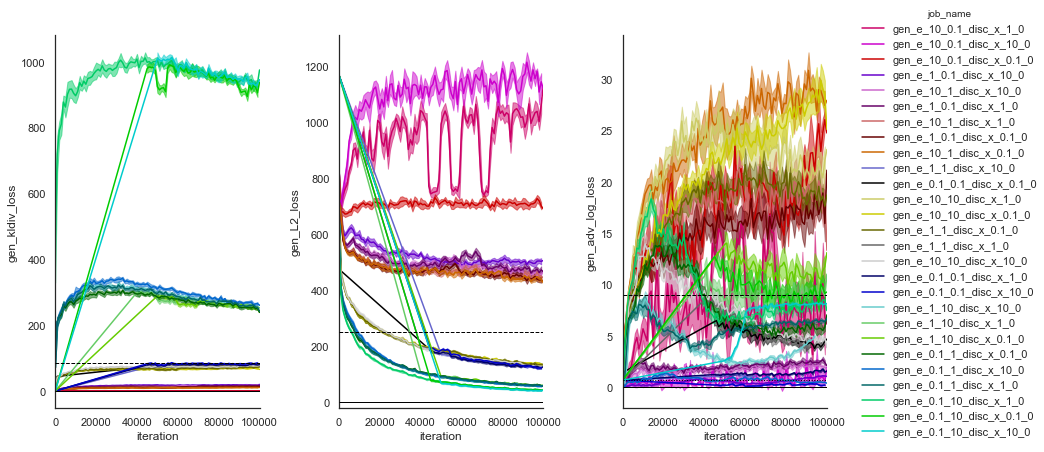

In [46]:
from results import plot_lines

plot_df = train_df[
    (train_df['phase'] == 'test')
]

iter_resolution = 1000
plot_df['iteration'] = (plot_df['iteration']//iter_resolution)*iter_resolution

x = 'iteration'
y = [
    'gen_kldiv_loss',   # red
    'gen_L2_loss',      # green
    'gen_adv_log_loss', # blue
]
hue = 'job_name'

fig = plot_lines('loss_weights_lines.png', plot_df, x=x, y=y, hue=hue,
                 n_cols=4, height=6, width=4, lgd_h=1.05,
                 hue_order=hue_order[::-1], colors=colors[::-1])

sns.despine(fig)

baselines = [85, 250, 9, 0.2] # est. from loss_types/gen_e_disc_x_0 at iteration 40-50k

for ax, bl in zip(fig.axes, baselines):
    xlim = ax.get_xlim()
    ax.hlines(bl, xlim[0], xlim[1], color='k', linestyle='--', linewidth=1, zorder=100)
    ax.set_xlim(*xlim)


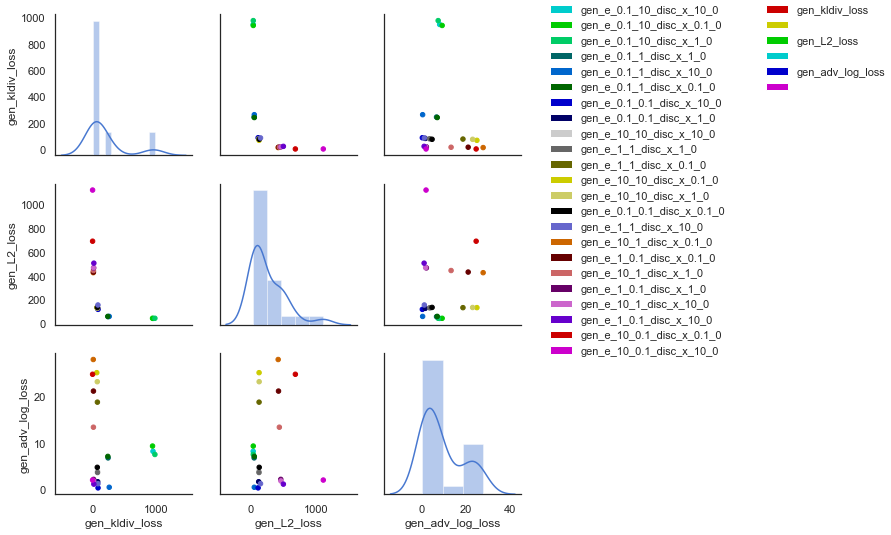

In [47]:
import matplotlib
from results import my_dist_plot
from collections import defaultdict

y = [
    'gen_kldiv_loss',
    'gen_L2_loss',
    'gen_adv_log_loss',
]

plot_df = agg_train_df[
    #(agg_train_df['gen_kldiv_loss'] < 1000) &
    #(agg_train_df['gen_L2_loss'] < 200) &
    #(agg_train_df['gen_adv_log_loss'] < 20) &
    (agg_train_df['is_pareto'])
]

plot_file = 'loss_weight_corr.png'
height = 2.5
width = 2.5

g = sns.PairGrid(
    plot_df,
    x_vars=y,
    y_vars=y,
    height=height,
    aspect=width/float(height),
    diag_sharey=False,
)

g.map_diag(my_dist_plot)
g.map_offdiag(plt.scatter, s=20, color=plot_df[color_col])
fig = g.fig

# job names legend
handles, labels = [], []
for i, row in plot_df.iterrows():
    p = matplotlib.patches.Patch(facecolor=row[color_col])
    handles.append(p)
    labels.append(row['job_name'])

fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False)

# loss colors legend
handles, labels = [], []
for i in range(3):
    color = tuple([color_max if j == i else color_min for j in range(3)])
    label = y[i] #'{} = {:.2f}'.format(y[i], plot3_df[y[i]].min())
    p = matplotlib.patches.Patch(facecolor=color)
    handles.append(p)
    labels.append(label)

    color = tuple([color_max if j in [i, (i+1)%3] else color_min for j in range(3)])
    label = ''
    p = matplotlib.patches.Patch(facecolor=color),
    handles.append(p)
    labels.append(label)
    
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.4, 1.0), frameon=False)

fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.2)
fig.savefig(plot_file, bbox_inches='tight')

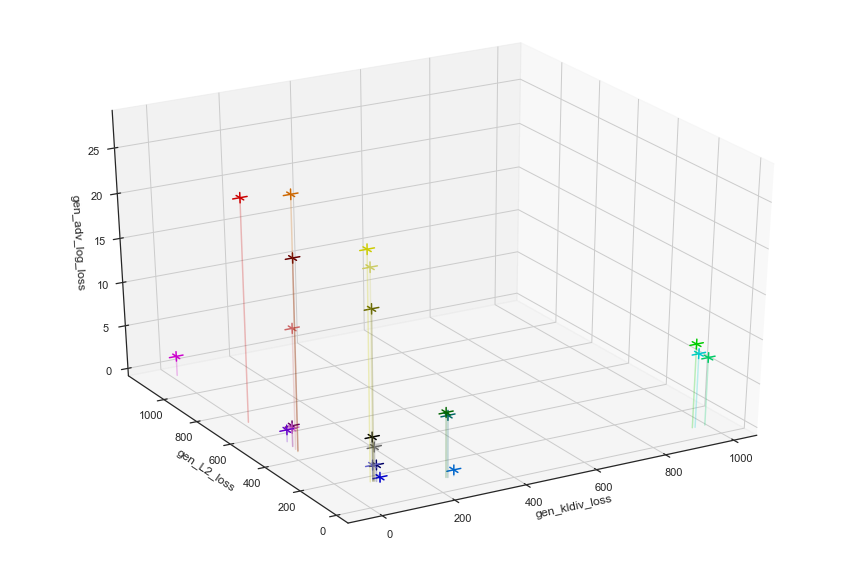

In [32]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

x = 'gen_kldiv_loss'
y = 'gen_L2_loss'
z = 'gen_adv_log_loss'

x_size = (plot_df[x].max() - plot_df[x].min()) * 0.02
y_size = (plot_df[y].max() - plot_df[y].min()) * 0.02
z_size = (plot_df[z].max() - plot_df[z].min()) * 0.02
 
for i, row in plot_df.iterrows():
    color = row[color_col]
    x_ = [row[x] - x_size, row[x] + x_size]
    y_ = [row[y], row[y]]
    z_ = [row[z], row[z]]
    ax.plot(x_, y_, z_, c=color, alpha=1.0)
    x_ = [row[x], row[x]]
    y_ = [row[y] - y_size, row[y] + y_size]
    z_ = [row[z], row[z]]
    ax.plot(x_, y_, z_, c=color, alpha=1.0)
    x_ = [row[x], row[x]]
    y_ = [row[y], row[y]]
    z_ = [row[z] - z_size, row[z] + z_size]
    ax.plot(x_, y_, z_, c=color, alpha=1.0)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
z_lim = ax.get_zlim()

for i, row in plot_df.iterrows():
    color = row[color_col]
    #x_ = [row[x], x_lim[1]]
    #y_ = [row[y], row[y]]
    #z_ = [row[z], row[z]]
    #ax.plot(x_, y_, z_, c=color, alpha=0.25)
    #x_ = [row[x], row[x]]
    #y_ = [row[y], y_lim[1]]
    #z_ = [row[z], row[z]]
    #ax.plot(x_, y_, z_, c=color, alpha=0.25)
    x_ = [row[x], row[x]]
    y_ = [row[y], row[y]]
    z_ = [z_lim[0], row[z]]
    ax.plot(x_, y_, z_, c=color, alpha=0.25)

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_zlim(z_lim)
    
ax.view_init(30, 180+60)

ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)

fig.tight_layout()

In [48]:
fit_files = [
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights\\crc_fit_molport2.gen_metrics',
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights\\csb_fit_pubchem2.gen_metrics',
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights\\csb_fit_molport2.gen_metrics',
]
expt_param_names = ['expt_name', 'cluster']

fit_dfs = []
for fit_file in fit_files:
    fit_df = pd.read_csv(fit_file, sep=' ')
    cluster, expt_name = os.path.splitext(os.path.basename(fit_file))[0].split('_', 1)
    fit_df['expt_name'] = expt_name
    fit_df['cluster'] = cluster
    fit_dfs.append(fit_df)
    print(fit_file)
        
fit_df = pd.concat(fit_dfs)

C:\Users\mtr22\Code\liGAN\train_molport\loss_weights\crc_fit_molport2.gen_metrics


c:\users\mtr22\code\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (32,35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


C:\Users\mtr22\Code\liGAN\train_molport\loss_weights\csb_fit_pubchem2.gen_metrics
C:\Users\mtr22\Code\liGAN\train_molport\loss_weights\csb_fit_molport2.gen_metrics


In [49]:
from functools import lru_cache

job_param_names = ['job_name', 'variational', 'gen_loss_type', 'KL_loss_weight', 'L2_loss_weight',
                   'disc_loss_type', 'GAN_loss_weight', 'random_seed', 'train_job_name', 'loss_weights',
                   'iteration', 'prior', 'data_name', 'train_sim', 'AE/VAE', 'dataset']

job_name_formats = {
    'AE_molport': 'ae_disc_{disc_loss_type}_{random_seed}_{iteration}_{fit_options}',
    'AE_pubchem': 'ae_disc_{disc_loss_type}_{random_seed}_{iteration}_{fit_options}_{data_name}',
    'VAE_molport': 'gen_{gen_loss_type}_{KL_loss_weight}_{L2_loss_weight}_disc_{disc_loss_type}_{GAN_loss_weight}' \
        '_{random_seed}_{iteration}_{fit_options}',
    'VAE_pubchem': 'gen_{gen_loss_type}_{KL_loss_weight}_{L2_loss_weight}_disc_{disc_loss_type}_{GAN_loss_weight}' \
        '_{random_seed}_{iteration}_{fit_options}_{data_name}',
}

@lru_cache(100)
def parse_job_name(job_name):
    
    variational = job_name.startswith('gen_')
    is_pubchem = 'pubchem' in job_name

    # get correct format for parsing job name
    if variational:
        if is_pubchem:
            job_name_format = job_name_formats['VAE_pubchem']
        else:
            job_name_format = job_name_formats['VAE_molport']
    else:
        if is_pubchem:
            job_name_format = job_name_formats['AE_pubchem']
        else:
            job_name_format = job_name_formats['AE_molport']
            
    # parse job name to get job params
    job_params = parse.parse(job_name_format, job_name).named
    job_params['job_name'] = job_name
    
    if variational:
        job_params['AE/VAE'] = 'VAE'
    else:
        job_params['AE/VAE'] = 'AE'
    
    if is_pubchem:
        job_params['dataset'] = 'pubchem'
        job_params['train_sim'] = float(job_params['data_name'][len('pubchem_diff'):])
    else:
        job_params['data_name'] = 'molportFULL_rand_test0'
        job_params['dataset'] = 'molport'
        job_params['train_sim'] = 1.0
        
    job_params['variational'] = variational
    
    if not variational:
        job_params['gen_loss_type'] = 'e'

    # parse fit_options flags into new boolean params
    fit_options = job_params['fit_options']
    job_params['prior'] = 'p' in fit_options
    job_params['random_rotation'] = 'r' in fit_options
    
    train_job_name_format = job_name_format.split('_{iteration}_')[0]
    job_params['train_job_name'] = train_job_name_format.format(**job_params)
    
    # convert data types of numeric params
    if variational:
        job_params['KL_loss_weight'] = float(job_params['KL_loss_weight'])
        job_params['L2_loss_weight'] = float(job_params['L2_loss_weight'])
        job_params['GAN_loss_weight'] = float(job_params['GAN_loss_weight'])
    else:
        job_params['KL_loss_weight'] = 1.0
        job_params['L2_loss_weight'] = 1.0
        job_params['GAN_loss_weight'] = 1.0
        
    job_params['iteration']   = int(job_params['iteration'])
    job_params['random_seed'] = int(job_params['random_seed'])
    
    # add other params
    job_params['loss_weights'] = str((job_params['KL_loss_weight'],
                                      job_params['L2_loss_weight'],
                                      job_params['GAN_loss_weight']))

    return pd.Series([job_params[p] for p in job_param_names])

fit_df[job_param_names] = fit_df['job_name'].apply(parse_job_name)

def dtype(series):
    return series.dtype

param_names = expt_param_names + job_param_names

fit_df[param_names + ['lig_name']].agg([dtype, pd.Series.nunique, pd.Series.unique]).transpose()

,dtype,nunique,unique
expt_name,object,2,"[fit_molport2, fit_pubchem2]"
cluster,object,2,"[crc, csb]"
job_name,object,568,"[gen_e_0.1_0.1_disc_x_0.1_0_100000_pr, gen_e_0..."
variational,bool,2,"[True, False]"
gen_loss_type,object,1,[e]
KL_loss_weight,float64,3,"[0.1, 10.0, 1.0]"
L2_loss_weight,float64,3,"[0.1, 10.0, 1.0]"
disc_loss_type,object,1,[x]
GAN_loss_weight,float64,3,"[0.1, 10.0, 1.0]"
random_seed,int64,1,[0]


In [35]:
pd.set_option('display.max_rows', 1000)
final_train_job_names = ['ae_disc_x_0', 'gen_e_0.1_1_disc_x_10_0']
fit_df[
    fit_df['train_job_name'].isin(final_train_job_names)
].groupby(['train_job_name', 'iteration', 'data_name', 'prior', 'lig_name']).mean() \
 .groupby(['train_job_name', 'iteration', 'data_name', 'prior'])[['array_idx']].agg(['count', min, max, sorted])

array_idx  \
                                                                   count   
train_job_name          iteration data_name              prior             
ae_disc_x_0             10000     molportFULL_rand_test0 False       213   
                        20000     molportFULL_rand_test0 False       213   
                        30000     molportFULL_rand_test0 False       212   
                        40000     molportFULL_rand_test0 False       211   
                        50000     molportFULL_rand_test0 False       210   
                        60000     molportFULL_rand_test0 False       210   
                        70000     molportFULL_rand_test0 False       210   
                        80000     molportFULL_rand_test0 False       210   
                        90000     molportFULL_rand_test0 False       210   
                        100000    molportFULL_rand_test0 False       210   
                                  pubchem_diff0.0        False        14   
                                  pubchem_diff0.1        False       999   
                                  pubchem_diff0.2        False      1000   
                                  pubchem_diff0.3        False      1000   
                                  pubchem_diff0.4        False      1000   
                                  pubchem_diff0.5        False      1000   
                                  pubchem_diff0.6        False      1000   
                                  pubchem_diff0.7        False      1000   
                                  pubchem_diff0.8        False      1000   
                                  pubchem_diff0.9        False      1000   
gen_e_0.1_1_disc_x_10_0 10000     molportFULL_rand_test0 False       532   
                                                         True        533   
                        20000     molportFULL_rand_test0 False       531   
                                                         True        532   
                        30000     molportFULL_rand_test0 False       532   
                                                         True        531   
                        40000     molportFULL_rand_test0 False       532   
                                                         True        531   
                        50000     molportFULL_rand_test0 False       531   
                                                         True        531   
                        60000     molportFULL_rand_test0 False       531   
                                                         True        532   
                        70000     molportFULL_rand_test0 False       530   
                                                         True        532   
                        80000     molportFULL_rand_test0 False       530   
                                                         True        532   
                        90000     molportFULL_rand_test0 False       531   
                                                         True        533   
                        100000    molportFULL_rand_test0 False       532   
                                                         True        533   
                                  pubchem_diff0.0        False        14   
                                                         True         14   
                                  pubchem_diff0.1        False       999   
                                                         True        999   
                                  pubchem_diff0.2        False      1000   
                                                         True       1000   
                                  pubchem_diff0.3        False      1000   
                                                         True       1000   
                                  pubchem_diff0.4        False      1000   
                                                         True       1000   
                                  p

In [36]:
fit_df['lig_fit_exact_types'] = (fit_df['lig_fit_type_diff'] == 0)
fit_df['lig_gen_fit_exact_types'] = (fit_df['lig_gen_fit_type_diff'] == 0)

fit_df['lig_gen_fit_add_dvalid'] = (fit_df['lig_gen_fit_add_valid'].astype(int) - fit_df['lig_gen_fit_valid'].astype(int))

fit_df['lig_gen_fit_add_logE'] = np.log10(fit_df['lig_gen_fit_add_E'])
fit_df['lig_gen_fit_add_min_logE'] = np.log10(fit_df['lig_gen_fit_add_min_E'])

c:\users\mtr22\code\miniconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\mtr22\code\miniconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [39]:
# assign colors to job_names

color_map['ae_disc_x_0'] = (0.0, 0.0, 0.0)

fit_df['hue_order'] = fit_df['train_job_name'].map(list(color_map.keys()).index)
fit_df[color_col] = fit_df['train_job_name'].map(color_map.__getitem__)
fit_df['is_pareto'] = fit_df['train_job_name'].map(pareto_front.__contains__)

agg_fit_df = fit_df \
    .groupby(['train_job_name', 'iteration', 'dataset', 'train_sim', 'prior', 'hue_order', color_col]).mean().reset_index() \
    .groupby(['train_job_name', 'dataset', 'train_sim', 'prior', 'hue_order', color_col]).last().reset_index()

agg_fit_df = agg_fit_df.sort_values('hue_order')

hue_order2 = list(agg_fit_df['hue_order'].values)
colors2 = list(agg_fit_df[color_col].values)

agg_fit_df[~agg_fit_df['prior'] & (agg_fit_df['dataset'] == 'molport')].head(top_n+2)

,train_job_name,dataset,train_sim,prior,hue_order,weight_color,iteration,Unnamed: 0,sample_idx,lig_norm,...,array_idx,variational,KL_loss_weight,L2_loss_weight,GAN_loss_weight,random_seed,lig_gen_fit_add_dvalid,lig_gen_fit_add_logE,lig_gen_fit_add_min_logE,is_pareto
19,gen_e_0.1_10_disc_x_10_0,molport,1.0,False,0,"(0.0, 0.8, 0.8)",100000,4.5,4.5,37.132387,...,5.500000,1.0,0.1,10.0,10.0,0.0,0.30000,4.280039,2.106511,1.0
17,gen_e_0.1_10_disc_x_0.1_0,molport,1.0,False,1,"(0.0, 0.8, 0.0)",100000,4.5,4.5,37.132387,...,5.500000,1.0,0.1,10.0,0.1,0.0,0.27000,4.447564,2.134069,1.0
21,gen_e_0.1_10_disc_x_1_0,molport,1.0,False,2,"(0.0, 0.8, 0.4)",100000,4.5,4.5,37.132387,...,5.500000,1.0,0.1,10.0,1.0,0.0,0.37000,4.621530,2.051958,1.0
47,gen_e_0.1_1_disc_x_1_0,molport,1.0,False,3,"(0.0, 0.4, 0.4)",100000,4.5,4.5,37.132387,...,5.500000,1.0,0.1,1.0,1.0,0.0,0.47000,4.694079,2.051745,1.0
25,gen_e_0.1_1_disc_x_10_0,molport,1.0,False,4,"(0.0, 0.4, 0.8)",100000,4.5,4.5,38.829146,...,11918.385609,1.0,0.1,1.0,10.0,0.0,0.51845,4.951964,2.185795,1.0
23,gen_e_0.1_1_disc_x_0.1_0,molport,1.0,False,5,"(0.0, 0.4, 0.0)",100000,4.5,4.5,37.132387,...,5.500000,1.0,0.1,1.0,0.1,0.0,0.51000,4.961531,2.118288,1.0
73,gen_e_1_10_disc_x_0.1_0,molport,1.0,False,6,"(0.4, 0.8, 0.0)",100000,4.5,4.5,37.132387,...,5.500000,1.0,1.0,10.0,0.1,0.0,0.52000,4.625300,2.108164,0.0
77,gen_e_1_10_disc_x_1_0,molport,1.0,False,7,"(0.4, 0.8, 0.4)",100000,4.5,4.5,37.132387,...,5.500000,1.0,1.0,10.0,1.0,0.0,0.52000,4.769645,2.094973,0.0
75,gen_e_1_10_disc_x_10_0,molport,1.0,False,8,"(0.4, 0.8, 0.8)",90000,4.5,4.5,37.132387,...,5.500000,1.0,1.0,10.0,10.0,0.0,0.56000,5.161170,2.140757,0.0
13,gen_e_0.1_0.1_disc_x_10_0,molport,1.0,False,9,"(0.0, 0.0, 0.8)",100000,4.5,4.5,37.132387,...,5.500000,1.0,0.1,0.1,10.0,0.0,0.62000,5.539595,2.214762,1.0


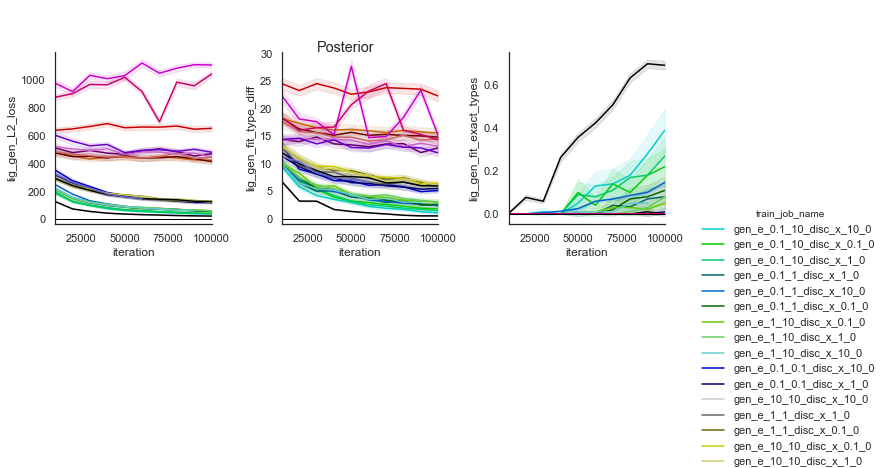

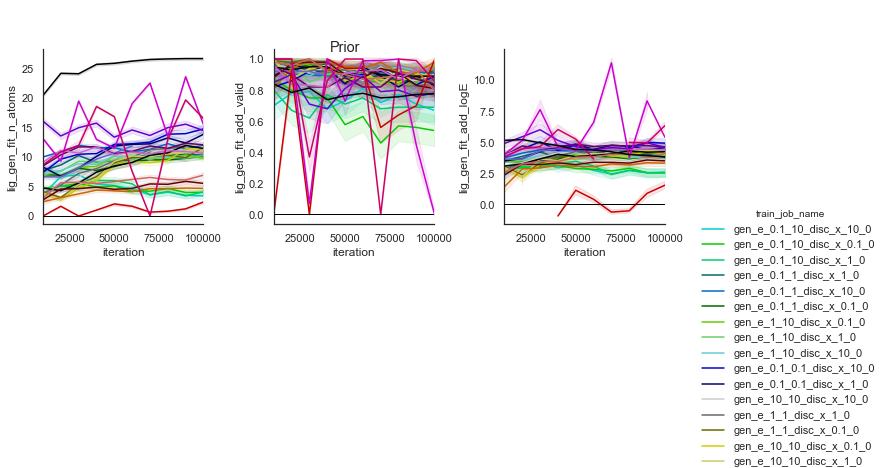

In [41]:
from results import plot_lines

plot_df = fit_df[
    (fit_df['dataset'] == 'molport') &
    (
        (
            fit_df['variational'] &
            ~fit_df['prior']
        ) |
        (
            fit_df['train_job_name'] == 'ae_disc_x_0'
        )
    )
]

hue_order = [j for j in color_map.keys() if j in set(plot_df['train_job_name'].values)]

#old_job_name = 'gen_e_1_1_disc_x_1_0'
#new_job_name = 'gen_e_0.1_1_disc_x_10_0'
#hue_order.append(hue_order.pop(hue_order.index(old_job_name)))
#hue_order.append(hue_order.pop(hue_order.index(new_job_name)))

colors = [color_map[j] for j in hue_order]

x = 'iteration'
y = [
    #'lig_gen_norm',
    #'lig_gen_variance',
    'lig_gen_L2_loss',
    
    #'lig_gen_fit_n_atoms',
    'lig_gen_fit_type_diff',
    'lig_gen_fit_exact_types',
    
    #'lig_gen_fit_valid',
    #'lig_gen_fit_add_valid',
    #'lig_gen_fit_add_dvalid',
    
    #'lig_gen_fit_add_QED',
    #'lig_gen_fit_add_ob_sim',
    #'lig_gen_fit_add_SMILES_match',
    
    #'lig_gen_fit_add_logE',
    #'lig_gen_fit_add_min_logE',
    #'lig_gen_fit_add_RMSD_min',    
]
hue = 'train_job_name'

fig = plot_lines('loss_weights_fit_lines.png', plot_df, x=x, y=y, hue=hue, alpha=1/10,
                  n_cols=4, height=3.25, width=3.25, lgd_h=1.15, hue_order=hue_order, colors=colors)
fig.suptitle('Posterior')
sns.despine(fig)

plot_df = fit_df[
    (fit_df['dataset'] == 'molport') &
    (
        (
            fit_df['variational'] &
            fit_df['prior']
        ) |
        (
            fit_df['train_job_name'] == 'ae_disc_x_0'
        )
    )
]


x = 'iteration'
y = [
    #'lig_gen_norm',
    #'lig_gen_variance',
    #'lig_gen_L2_loss',
    
    'lig_gen_fit_n_atoms',
    #'lig_gen_fit_type_diff',
    #'lig_gen_fit_exact_types',
    
    'lig_gen_fit_add_valid',
    #'lig_gen_fit_add_valid',
    #'lig_gen_fit_add_dvalid',
    
    #'lig_gen_fit_add_QED',
    #'lig_gen_fit_add_ob_sim',
    #'lig_gen_fit_add_SMILES_match',
    
    'lig_gen_fit_add_logE',
    #'lig_gen_fit_add_min_logE',
    #'lig_gen_fit_add_RMSD_min',    
]
hue = 'train_job_name'

fig = plot_lines('loss_weights_fit_lines.png', plot_df, x=x, y=y, hue=hue, alpha=1/10,
                  n_cols=4, height=3.25, width=3.25, lgd_h=1.15, hue_order=hue_order, colors=colors)
fig.suptitle('Prior')
sns.despine(fig)

In [56]:
plot_df

,Unnamed: 0,lig_name,sample_idx,lig_norm,lig_gen_norm,lig_latent_norm,lig_gen_L2_loss,lig_variance,lig_gen_variance,lig_fit_L2_loss,...,iteration,prior,data_name,train_sim,lig_gen_fit_add_dvalid,lig_gen_fit_add_logE,lig_gen_fit_add_min_logE,hue_order,weight_color,is_pareto
180390,0,PubChem-44754949_0,0,22.386175,10.722408,0.186136,185.633072,77.071793,41.026691,0.000036,...,100000,False,pubchem_diff0.0,0.0,1,2.908406,NaN,27,"(0.0, 0.0, 0.0)",False
180391,1,PubChem-44754949_0,1,22.385790,10.844790,0.186707,185.273483,93.601456,48.605331,0.000029,...,100000,False,pubchem_diff0.0,0.0,1,2.892527,NaN,27,"(0.0, 0.0, 0.0)",False
180392,2,PubChem-44754949_0,2,22.386009,10.318521,0.189584,186.741409,82.680328,39.095741,0.000030,...,100000,False,pubchem_diff0.0,0.0,1,2.873923,NaN,27,"(0.0, 0.0, 0.0)",False
180393,3,PubChem-44754949_0,3,22.386238,11.037033,0.194191,187.415329,101.595078,52.839317,0.000027,...,100000,False,pubchem_diff0.0,0.0,1,2.853263,NaN,27,"(0.0, 0.0, 0.0)",False
180394,4,PubChem-44754949_0,4,22.386047,10.006139,0.184135,187.059113,77.317574,39.096432,0.000025,...,100000,False,pubchem_diff0.0,0.0,1,2.950926,NaN,27,"(0.0, 0.0, 0.0)",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270515,5,PubChem-61111496_0,5,35.399170,36.289108,0.351453,7.925390,891.153687,945.821960,5.379865,...,100000,False,pubchem_diff0.9,0.9,0,2.359163,1.679553,27,"(0.0, 0.0, 0.0)",False
270516,6,PubChem-61111496_0,6,35.399426,35.808304,0.341413,9.627405,979.854126,995.785889,0.000081,...,100000,False,pubchem_diff0.9,0.9,0,2.512665,1.679553,27,"(0.0, 0.0, 0.0)",False
270517,7,PubChem-61111496_0,7,35.399578,35.674290,0.345827,11.740628,911.236755,926.442627,0.000071,...,100000,False,pubchem_diff0.9,0.9,-1,NaN,NaN,27,"(0.0, 0.0, 0.0)",False
270518,8,PubChem-61111496_0,8,35.399479,36.182518,0.352314,9.319757,976.807007,1018.894897,0.000079,...,100000,False,pubchem_diff0.9,0.9,0,2.602703,1.679553,27,"(0.0, 0.0, 0.0)",False


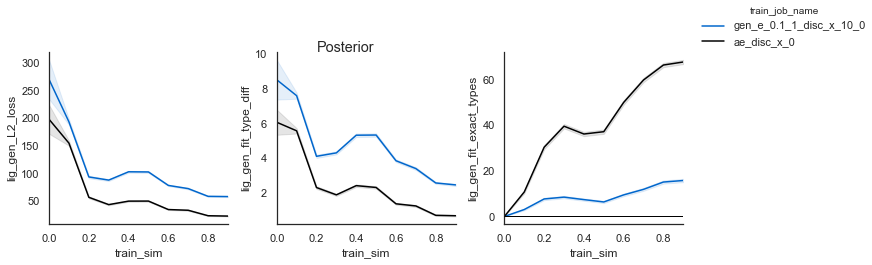

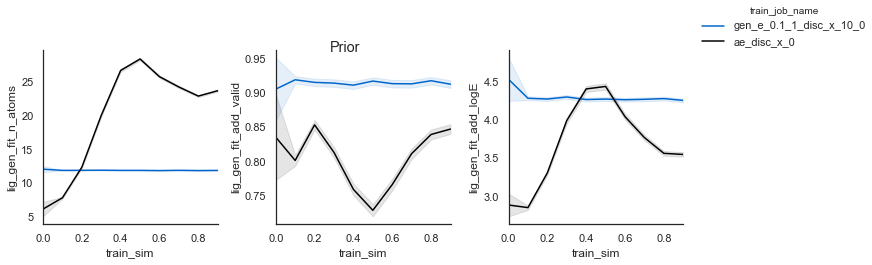

In [57]:
from results import plot_lines

plot_df = fit_df[
    (
        (~fit_df['prior']) &
        (fit_df['train_sim'] < 1.0)
    ) |
    (fit_df['train_job_name'] == 'ae_disc_x_0')
]

hue_order = [j for j in color_map.keys() if j in set(plot_df['train_job_name'].values)]

#old_job_name = 'gen_e_1_1_disc_x_1_0'
#new_job_name = 'gen_e_0.1_1_disc_x_10_0'
#hue_order.insert(0, hue_order.pop(hue_order.index(old_job_name)))
#hue_order.insert(0, hue_order.pop(hue_order.index(new_job_name)))

colors = [color_map[j] for j in hue_order]

x = 'train_sim'
y = [
    #'lig_gen_norm',
    #'lig_gen_variance',
    'lig_gen_L2_loss',
    
    #'lig_gen_fit_n_atoms',
    'lig_gen_fit_type_diff',
    'lig_gen_fit_exact_types',
    
    #'lig_gen_fit_valid',
    #'lig_gen_fit_add_valid',
    #'lig_gen_fit_add_dvalid',
    
    #'lig_gen_fit_add_QED',
    #'lig_gen_fit_add_ob_sim',
    #'lig_gen_fit_add_SMILES_match',
    
    #'lig_gen_fit_add_logE',
    #'lig_gen_fit_add_min_logE',
    #'lig_gen_fit_add_RMSD_min',    
]
hue = 'train_job_name'

fig = plot_lines('loss_weights_fit_lines.png', plot_df, x=x, y=y, hue=hue, alpha=1/10, lead_x=0,
                  n_cols=4, height=3.25, width=3.25, lgd_h=1.15, hue_order=hue_order, colors=colors)
fig.suptitle('Posterior')
sns.despine(fig)

plot_df = fit_df[
    (
        (fit_df['prior']) &
        (fit_df['train_sim'] < 1.0)
    ) |
    (fit_df['train_job_name'] == 'ae_disc_x_0')
]

x = 'train_sim'
y = [
    #'lig_gen_norm',
    #'lig_gen_variance',
    #'lig_gen_L2_loss',
    
    'lig_gen_fit_n_atoms',
    #'lig_gen_fit_type_diff',
    #'lig_gen_fit_exact_types',
    
    'lig_gen_fit_add_valid',
    #'lig_gen_fit_add_valid',
    #'lig_gen_fit_add_dvalid',
    
    #'lig_gen_fit_add_QED',
    #'lig_gen_fit_add_ob_sim',
    #'lig_gen_fit_add_SMILES_match',
    
    'lig_gen_fit_add_logE',
    #'lig_gen_fit_add_min_logE',
    #'lig_gen_fit_add_RMSD_min',    
]
hue = 'train_job_name'

fig = plot_lines('loss_weights_fit_lines.png', plot_df, x=x, y=y, hue=hue, alpha=1/10, lead_x=0,
                  n_cols=4, height=3.25, width=3.25, lgd_h=1.15, hue_order=hue_order, colors=colors)
fig.suptitle('Prior')
sns.despine(fig)

In [159]:
agg_fit_df.set_index(param_names).unstack().columns #['lig_gen_fit_n_atoms']

KeyError: "None of ['expt_name', 'cluster', 'job_name', 'gen_loss_type', 'disc_loss_type', 'loss_weights'] are in the columns"

In [ ]:
fit_df['Method'] = 

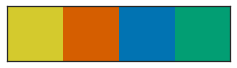

In [50]:
def shift(a, n):
    return np.array([a[(i+n)%len(a)] for i in range(len(a))])

colors = sns.color_palette('colorblind')
color_names = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'teal']
colors = pd.Series(colors, index=color_names)
colors['yellow'] = tuple(0.9 * np.array(colors['yellow']))
colors = colors[['yellow', 'red', 'blue', 'green']]

sns.set_palette(colors)
sns.set_context('notebook')
sns.set_style('white')

sns.palplot(colors)

C:\Users\mtr22\Code\liGAN\results.py:565: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


KeyError: 'gen_e_0.1_10_disc_x_10_0'

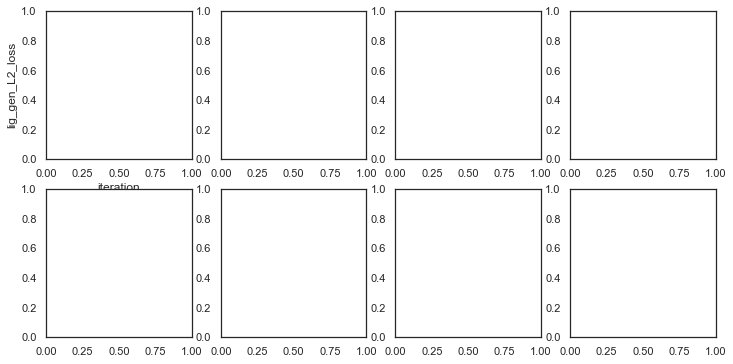

In [51]:
import results
from results import add_group_column, plot_lines

plot_df = fit_df[
    (fit_df['dataset'] == 'molport') &
    (
        (fit_df['train_job_name'] == 'ae_disc_x_0') |
        (fit_df['train_job_name'] == 'gen_e_0.1_1_disc_x_10_0')
    )
]

x = 'iteration'
y = [
    'lig_gen_L2_loss',
    'lig_gen_fit_type_diff',
    'lig_gen_fit_exact_types',
    'lig_gen_fit_n_atoms',
    
    'lig_gen_fit_valid',
    'lig_gen_fit_add_ob_sim',
    'lig_gen_fit_add_SMILES_match',
    'lig_gen_fit_add_QED',  
]
ylim = [
    (0, 450), (0, 17), (0, 110), (0, 30),
    (0, 1.10), (0, 1), (0, 1.00), (0, 0.8)
]
hue = add_group_column(plot_df, ['train_job_name', 'prior'])

fig = plot_lines('loss_weights_fit_lines.png', plot_df, x=x, y=y, hue=hue, hue_order=hue_order, colors=colors,
                  n_cols=4, height=3, width=3, despine=True, lead_x=0, ylim=ylim, alpha=1/5,
                  title='Training Progress', center_lgd=False, lgd_title=False, lgd_h=0.895)


C:\Users\mtr22\Code\liGAN\results.py:562: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[group] = df[group_cols].apply(lambda x: str(tuple(x)), axis=1)


KeyError: 'gen_e_0.1_1_disc_x_10_0'

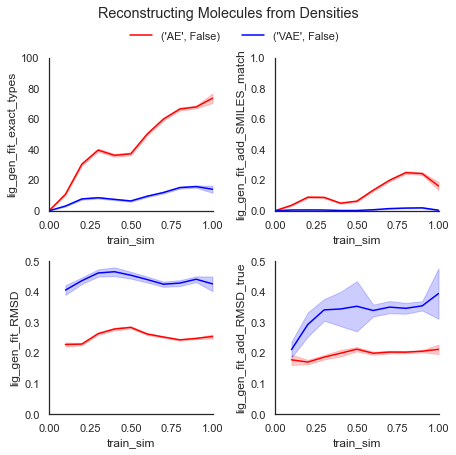

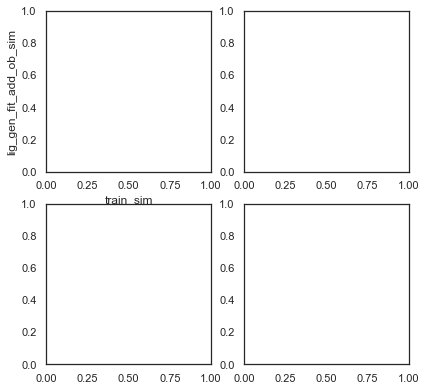

In [128]:
from results import add_group_column, plot_lines

plot_df = fit_df[
    (fit_df['iteration'] == 100000) &
    (~fit_df['prior']) &
    (
        (fit_df['train_job_name'] == 'gen_e_0.1_1_disc_x_10_0') |
        (fit_df['train_job_name'] == 'ae_disc_x_0')
    )
]

hue_order = [j for j in color_map.keys() if j in set(plot_df['train_job_name'].values)]
colors = [color_map[j] for j in hue_order]

x = 'train_sim'
y = [
    'lig_gen_fit_exact_types',
    'lig_gen_fit_add_SMILES_match',
    'lig_gen_fit_RMSD',
    'lig_gen_fit_add_RMSD_true',
]

ylim = [
    (0, 100),
    (0, 1.0),
    (0, 0.5),
    (0, 0.5),

]
hue = add_group_column(plot_df, ['AE/VAE', 'prior'])

fig = plot_lines('loss_weights_fit_lines.png', plot_df, x=x, y=y, hue=hue, colors='rb',
                  n_cols=2, height=3.25, width=3.25, despine=True, lead_x=0, alpha=1/5, ylim=ylim,
                  title='Reconstructing Molecules from Densities', center_lgd=True, lgd_title=False, lgd_h=0.895)


from results import add_group_column, plot_lines

plot_df = fit_df[
    (fit_df['iteration'] == 100000) &
    (fit_df['prior']) &
    (
        (fit_df['train_job_name'] == 'gen_e_0.1_1_disc_x_10_0') |
        (fit_df['train_job_name'] == 'ae_disc_x_0')
    )
]

hue_order = [j for j in color_map.keys() if j in set(plot_df['train_job_name'].values)]
colors = [color_map[j] for j in hue_order]

x = 'train_sim'
y = [
   
    'lig_gen_fit_add_ob_sim',
    'lig_gen_fit_add_MW',
    'lig_gen_fit_add_QED',
    'lig_gen_fit_add_SAS',
]

ylim = [
    (0, 1.0),
    (0, 1000),
    (0, 0.7),
    (0, 7)
]
hue = add_group_column(plot_df, ['AE/VAE', 'prior'])

fig = plot_lines('loss_weights_fit_lines.png', plot_df, x=x, y=y, hue=hue, hue_order=hue_order, colors=colors,
                  n_cols=2, height=3.25, width=3.25, despine=True, lead_x=0, alpha=1/5, ylim=ylim,
                  title='Sampling Novel Molecules from Latent Space', center_lgd=True, lgd_title=False, lgd_h=0.895)

In [112]:
[c for c in fit_df if 'rmsd' in c.lower()]

['lig_fit_RMSD',
 'lig_gen_fit_RMSD',
 'lig_RMSD_min',
 'lig_fit_add_RMSD_min',
 'lig_fit_add_RMSD_true',
 'lig_fit_add_min_RMSD_true',
 'lig_gen_fit_add_RMSD_min',
 'lig_gen_fit_add_RMSD_true',
 'lig_gen_fit_add_min_RMSD_true']